# Predicting stock seasonality using TimeSeries Forecasting 

#### This notebook covers the usage of various time series forecasting methods for predicting the stock seasonality and hence the best time of the year to invest in that stock

Based on the analysis of stock data and results of cross-validation following methods have been shortlisted:<br>
<ul>
<li>Seasonal decompose based seasonality forecasting: statsmodels, pmdarima
    <ol>
        <li>statsmodels - Seasonality:additive/multiplicative</li>
        <li>pmdarima - Seasonality:additive/multiplicative</li>
    </ol>
</li>
<li>Timeseries algorithms for seasonality forecasting: 
    <ol>
        <li>Holt-Winters - Trend:None/additive/multiplicative, Seasonality:additive/multiplicative </li>
        <li>Auto-ARIMA - Fourier featurizer to handle seasonality, with and without other exogenous features</li>
    </ol>
</li>
<li>Facebook Prophet for timeseries forecasting: 
    <ol>
        <li>Prediction based: Seasonality: yearly, Mode: additive/multiplicative, Growth:Linear/Logistic</li>
        <li>Seasonality based: Seasonality: yearly, Mode: additive/multiplicative, Growth:Linear/Logistic</li>
    </ol>
</li>
</ul>

In [1]:
import time
start = time.time()

In [2]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 

#Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

#PMD Arima
import pmdarima as pm
#print(f"Using pmdarima {pm.__version__}")

#FB Prophet
from fbprophet import Prophet

#Prediction Accuracy Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from numpy import *

%matplotlib inline
#pd.options.display.float_format = "{:,.4f}".format
pd.options.display.precision = 6
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [3]:
#Initialize the common variables
source_dir =  r'..\data\rawdata' + '\\'
transformed_dir =  r'..\data\inputdata' + '\\'
sma_rolling_window = 5 #Rolling window for simple moving average of stock price
eda_window = 5 #7 #Rolling window for stationarity analysis
min_train_data_years = 5
min_cross_val = 3
max_cross_val = 5
min_years_data_reqd = min_train_data_years + min_cross_val
current_year = datetime.datetime.now().year
stock_tickers = ['TWL'] #['VOLTAS', 'TWL', 'ESCORTS', 'MARUTI']
cnt_stocks = len(stock_tickers)
print('No. of stocks analysed:', cnt_stocks)
stock_ticker = stock_tickers[0]
print('Selected stock: ' + stock_ticker)

No. of stocks analysed: 1
Selected stock: TWL


### Load the stock data

In [4]:
group_by_col = 'year'
agg_value_col = 'adj_close'
agg_value_col_sma = 'sma'
wd_col = 'work_doy'
pctile_col = 'pctile'

In [5]:
def load_data(file_path):
    #Select required columns from csv
    #rawdata = pd.read_csv(file_path, index_col=0, usecols=['Date', 'Adj Close'], parse_dates=True)
    rawdata = None
    rawdata = pd.read_csv(file_path, index_col=0, parse_dates=True)
    rawdata = rawdata.dropna(how = 'any') ##Drop rows with empty cells
    rawdata.index.names = ['date']
    rawdata.rename(columns={"Adj Close": "adj_close"}, inplace = True)
    rawdata.sort_index(ascending = True, inplace = True)
    #Sort data by date
    return rawdata.copy()

In [6]:
data = load_data(source_dir + stock_ticker + '.csv')
#years_of_data = len(data.index.year.unique()) - 1 ##-1 for removing current year
data.head()

,High,Low,Open,Close,Volume,adj_close
date,,,,,,
2008-04-21,146.940002,108.000000,108.000000,28.273800,26922500.0,12.733235
2008-04-22,146.800003,132.320007,144.000000,134.210007,6925180.0,60.442093
2008-04-23,143.800003,129.220001,135.750000,142.100006,6394740.0,63.995399
2008-04-24,144.570007,135.110001,143.600006,137.149994,3148535.0,61.766136
2008-04-25,138.899994,133.119995,138.080002,134.369995,1002485.0,60.514153


### Transform data 
Add additional columns, remove current year data

<b>Note:</b> We are using a 5 day simple moving average(SMA) as an indicator of time frame for investment rather than a single day's close value. 
<br>Reasons:
<br>There could be multiple days with the same min. value spread across different time frames. Hence, it makes sense to use a simple moving average rather than individual close value.
<br>Also, this will avoid impact of any sudden surges/spikes in the analysis.

In [7]:
def transform_data(rawdf):
    #Simple moving average of adjusted close price with 2 prior and 2 next values
    rawdf['sma'] = rawdf.adj_close.rolling(window=sma_rolling_window, min_periods=1).mean().shift(-2)
    rawdf['year'] = rawdf.index.year
    #Drop current year's records from analysis
    rawdf = rawdf[rawdf.year < current_year] 
    rawdf["month"] = rawdf.index.month
    rawdf['week'] = pd.Int64Index(rawdf.index.isocalendar().week) #Deprecated - rawdf.index.week/weekofyear
    rawdf["day_of_week"] = rawdf.index.dayofweek
    rawdf["day_of_month"] = rawdf.index.day
    #Store day of year
    rawdf['day_of_year'] = rawdf.index.dayofyear
    #Add row count by year to get working day of year, this is column used for align prediction output
    rawdf[wd_col] = rawdf.groupby(['year']).cumcount() + 1
    #Add percentile using rank, this is column used for determining the accuracy of prediction
    rawdf[pctile_col] = 100 * rawdf.groupby("year")["sma"].rank("min", pct=True, ascending=True)    
    #Handle ISO week format for last days of year marked as Week 1
    rawdf.loc[(rawdf['week'] == 1) & (rawdf['day_of_year'] > 350),'week'] = 53 
    return rawdf.copy()

In [8]:
data = transform_data(data.copy())
data.tail(5)

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
date,,,,,,,,,,,,,,,
2019-12-24,45.750000,44.799999,45.549999,45.099998,298807.0,45.099998,46.080000,2019,12,52,1,24,358,238,33.471074
2019-12-26,47.900002,45.000000,45.000000,46.700001,525036.0,46.700001,46.760000,2019,12,52,3,26,360,239,36.776860
2019-12-27,47.500000,46.500000,46.900002,46.849998,434498.0,46.849998,47.489999,2019,12,52,4,27,361,240,38.429752
2019-12-30,50.299999,47.500000,48.000000,49.700001,1759715.0,49.700001,48.780000,2019,12,53,0,30,364,241,43.388430
2019-12-31,50.599998,48.700001,49.450001,49.099998,685539.0,49.099998,50.020000,2019,12,53,1,31,365,242,44.628099


In [9]:
data.describe()

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
count,2868.000000,2868.000000,2868.000000,2868.000000,2.868000e+03,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000
mean,82.956165,79.213724,81.036398,80.771445,8.633377e+05,64.368744,64.373164,2013.649233,6.597978,27.089958,1.990934,15.784170,185.448745,120.903417,50.207926
std,35.770945,34.077122,34.880317,34.844187,2.310279e+06,37.186761,37.110227,3.371702,3.408655,14.890658,1.412951,8.761806,104.200127,70.290836,28.873126
min,15.120000,13.930000,14.210000,14.420000,0.000000e+00,10.024644,10.386143,2008.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.400000
25%,61.980000,59.442500,60.764999,60.539999,1.541480e+05,37.219769,37.339815,2011.000000,4.000000,15.000000,1.000000,8.000000,98.000000,60.000000,25.203252
50%,79.735001,76.029999,77.584999,77.505001,3.487455e+05,51.367596,51.463003,2014.000000,7.000000,27.000000,2.000000,16.000000,186.000000,120.000000,50.248240
75%,108.825003,103.300003,106.025000,105.974998,7.571675e+05,94.393768,94.819035,2017.000000,9.250000,40.000000,3.000000,23.000000,274.000000,180.250000,75.203252
max,189.699997,179.199997,184.800003,184.649994,4.809918e+07,182.668472,179.463257,2019.000000,12.000000,53.000000,4.000000,31.000000,366.000000,250.000000,100.000000


In [10]:
wd_series = data[wd_col]
pctile_series = data[pctile_col]

### Aggregate Data
Derive important yearly metrics

In [11]:
#def agg_data(records):
def agg_data():
    #Aggregate data on yearly basis - Min. day of year will be our output
    year_agg_data = None
    year_agg_data = pd.concat([data.groupby(group_by_col)[agg_value_col].count().rename('record_cnt')
                          , data.groupby(group_by_col)[agg_value_col].mean().rename('mean_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col].min().rename('min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].min().rename('min_' + agg_value_col_sma)
                          , data.groupby(group_by_col)[agg_value_col].idxmin().rename('date_min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].idxmin().rename('date_min_' + agg_value_col_sma)
                          , data.groupby(group_by_col)[agg_value_col].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col_sma)
                          #, data.groupby(group_by_col)[agg_value_col].max().rename('max_' + agg_value_col)
                          #, data.groupby(group_by_col)[agg_value_col].median().rename('median_' + agg_value_col)
                          ], axis=1)
    ## Remove rows for years when the adj_close has -ve values
    year_agg_data = year_agg_data[year_agg_data.min_adj_close > 0]
    
    ##Get working day of min. price
    #wd_min_price = data.loc[data.groupby(group_by_col)[agg_value_col].idxmin()][[group_by_col, wd_col]].set_index([group_by_col])
    #wd_min_price.rename(columns={wd_col: 'wd_min_'+agg_value_col}, inplace = True)
    #wd_min_sma = data.loc[data.groupby(group_by_col)[agg_value_col_sma].idxmin()][[group_by_col, wd_col]].set_index([group_by_col])
    #wd_min_sma.rename(columns={wd_col: 'wd_min_'+agg_value_col_sma}, inplace = True)
    #year_agg_data = year_agg_data.join(wd_min_price).join(wd_min_sma) 
    year_agg_data['wd_min_'+agg_value_col] = year_agg_data.apply(lambda row: wd_series[row.date_min_adj_close], axis=1)
    year_agg_data['wd_min_'+agg_value_col_sma] = year_agg_data.apply(lambda row: wd_series[row.date_min_sma], axis=1)
    
    ## Check diff. between min. price working day based on actual value and moving avg.
    year_agg_data['target_doy_diff'] = abs(year_agg_data.doy_min_adj_close - year_agg_data.doy_min_sma)
    year_agg_data['target_wd_diff'] = abs(year_agg_data.wd_min_adj_close - year_agg_data.wd_min_sma)
    #return year_agg_data.copy()
    return year_agg_data

In [12]:
#year_agg_data = agg_data(data.copy())
year_agg_data = agg_data()
year_agg_data

,record_cnt,mean_adj_close,min_adj_close,min_sma,date_min_adj_close,date_min_sma,doy_min_adj_close,doy_min_sma,wd_min_adj_close,wd_min_sma,target_doy_diff,target_wd_diff
year,,,,,,,,,,,,
2008,171,54.511499,12.733235,26.244159,2008-04-21,2008-12-01,112,336,1,151,224,150
2009,236,27.103851,11.390041,11.842818,2009-03-12,2009-03-12,71,71,45,45,0,0
2010,250,43.397209,30.719992,31.441970,2010-05-25,2010-05-24,145,144,96,95,1,1
2011,246,45.886595,33.461075,33.704803,2011-03-22,2011-03-23,81,82,55,56,1,1
2012,245,43.494890,35.866329,36.143336,2012-06-19,2012-09-03,171,247,116,168,76,52
2013,248,23.347578,10.024644,10.386143,2013-08-02,2013-08-01,214,213,149,148,1,1
2014,244,38.294940,16.451164,16.652390,2014-02-14,2014-02-25,45,56,33,40,11,7
2015,246,105.987244,57.839268,59.191203,2015-01-07,2015-01-08,7,8,5,6,1,1
2016,246,106.233122,82.877899,84.459798,2016-05-24,2016-05-25,145,146,96,97,1,1


As indicated in the above dataframe, in most year's the date of min. adjusted close price is within a week of the date of min. adjusted simple moving avg. of close price. However, for some years, the value is very far. Hence, it is proven that it makes sense to use SMA

In [13]:
#Remove years when Adjusted close < 0
data = data[data.year >= year_agg_data.index.min()] 
data.head() 

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
date,,,,,,,,,,,,,,,
2008-04-21,146.940002,108.000000,108.000000,28.273800,26922500.0,12.733235,45.723576,2008,4,17,0,21,112,1,25.730994
2008-04-22,146.800003,132.320007,144.000000,134.210007,6925180.0,60.442093,49.734216,2008,4,17,1,22,113,2,30.409357
2008-04-23,143.800003,129.220001,135.750000,142.100006,6394740.0,63.995399,51.890203,2008,4,17,2,23,114,3,33.918129
2008-04-24,144.570007,135.110001,143.600006,137.149994,3148535.0,61.766136,61.549967,2008,4,17,3,24,115,4,58.479532
2008-04-25,138.899994,133.119995,138.080002,134.369995,1002485.0,60.514153,62.079585,2008,4,17,4,25,116,5,59.649123


In [14]:
year_agg_data.index.values

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019], dtype=int64)

##### Validate if sufficient data is available for forecasting

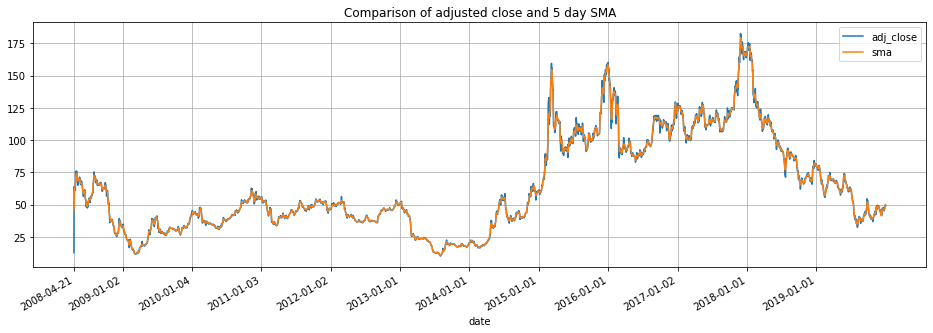

In [15]:
data[['adj_close', 'sma']].plot(figsize=(16,5), grid=True, xticks = data.groupby(group_by_col)[wd_col].idxmin())
plt.title('Comparison of adjusted close and 5 day SMA');

Text(0.5, 1.0, 'Adjusted close price perecentile values grouped on yearly basis')

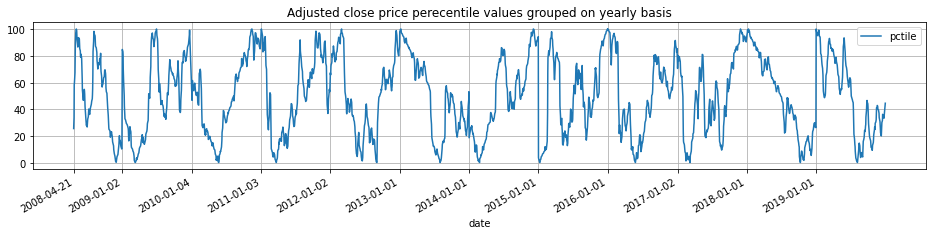

In [16]:
data[[pctile_col]].plot(figsize=(16,3), grid=True, xticks = data.groupby(group_by_col)[wd_col].idxmin())
plt.title('Adjusted close price perecentile values grouped on yearly basis')

In [17]:
years_of_data = len(year_agg_data) #len(data.index.year.unique())
print("Minimum", min_years_data_reqd, "years of historical data required for forecasting")  
print("Historical stocks data for", stock_ticker , "is available for", years_of_data, "years")
# Check min. years of data required for forecasting
if (years_of_data < min_years_data_reqd):    
    print("Historical stocks data for", stock_ticker, "is not sufficient for forecasting")

Minimum 8 years of historical data required for forecasting
Historical stocks data for TWL is available for 12 years


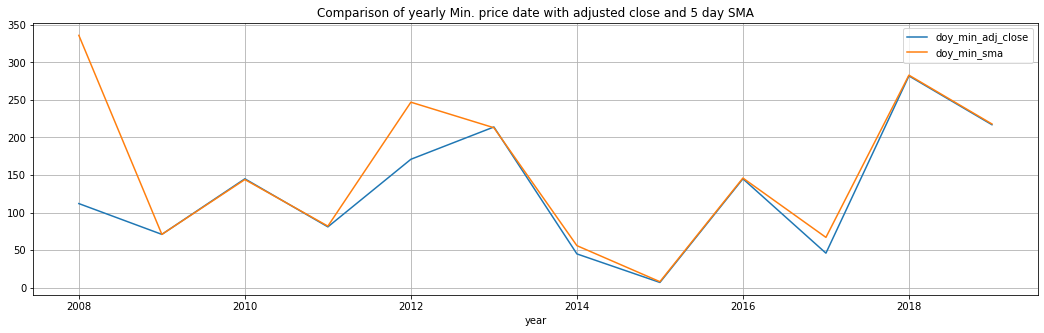

In [18]:
year_agg_data[['doy_min_adj_close', 'doy_min_sma']].plot(figsize=(18,5), grid=True)
plt.title('Comparison of yearly Min. price date with adjusted close and 5 day SMA');

## Build Train-Test Datasets

Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [19]:
frequency = int(round(len(data) / years_of_data, 0))
print('Average no. of records per year:', frequency)
cross_val = min(years_of_data - min_train_data_years, max_cross_val)
print('No. of cross validations, Test data period:', cross_val)
#test_data_years = min(years_of_data - min_train_data_years, max_cross_val)
#print('Test data period:', test_data_years, 'years')
train_data_years = len(year_agg_data) - cross_val
print('Train data period:', train_data_years, 'years')
split_year = current_year - cross_val
print('Cross validation begins from:', split_year)

Average no. of records per year: 239
No. of cross validations, Test data period: 5
Train data period: 7 years
Cross validation begins from: 2015


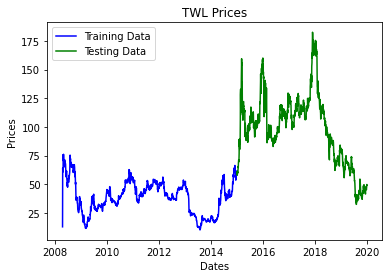

In [20]:
plt.figure(figsize=(6,4))
plt.title(stock_ticker + ' Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data[data.year < split_year] [agg_value_col], 'blue', label='Training Data')
plt.plot(data[data.year >= split_year] [agg_value_col], 'green', label='Testing Data')
plt.legend();

In [21]:
for i in range(cross_val):
    train_data = data[data.year < split_year + i] 
    test_data = data[data.year == split_year + i] 
    y_train = train_data[agg_value_col].values
    y_test = test_data[agg_value_col].values
    print(train_data.index.year.unique().values, test_data.index.year.unique().values)

[2008 2009 2010 2011 2012 2013 2014] [2015]
[2008 2009 2010 2011 2012 2013 2014 2015] [2016]
[2008 2009 2010 2011 2012 2013 2014 2015 2016] [2017]
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017] [2018]
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018] [2019]


### Auto-correlation plots
Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

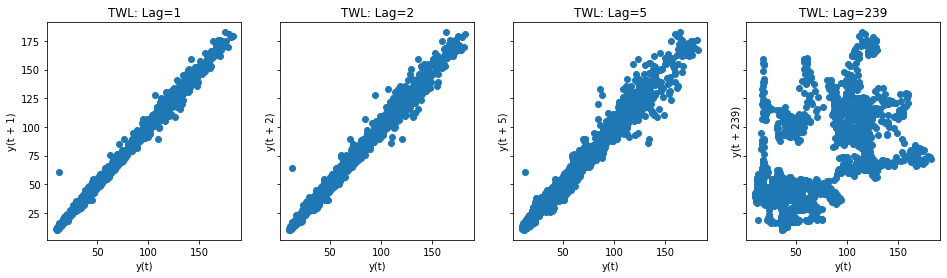

In [22]:
#from pandas.plotting import lag_plot
lags = [1, 2, 5, frequency]

fig, axes = plt.subplots(cnt_stocks, 4, squeeze=False, sharey='row'
                         , figsize=(16, 4*cnt_stocks))
plt.title('Autocorrelation plot')

for stk in range(cnt_stocks):
    for ax_col in range(4):
        axis = axes[stk][ax_col]
        pd.plotting.lag_plot(data[agg_value_col], lag=lags[ax_col], ax=axis)
        #axis.set_ylabel(stock_tickers[stk])
        axis.set_title(f"{stock_tickers[stk]}: Lag={lags[ax_col]}")

plt.show()

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

### Check for stationarity (Rolling mean and stdev)

In [23]:
data_series = data[agg_value_col]
data_diff = data_series.diff(periods=1).dropna(inplace = False)

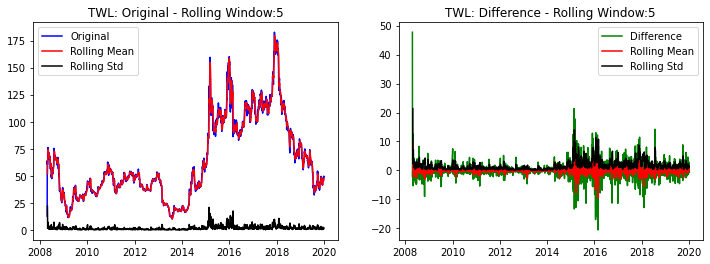

In [24]:
#Plot rolling statistics:
columns = 2
fig, axes = plt.subplots(cnt_stocks, columns, squeeze=False, #sharey='row',
                             figsize=(12, 4*cnt_stocks) )
plt.title('Rolling Mean & Standard Deviation');


for stk in range(cnt_stocks):
    axis = axes[stk][0]
    #Determing rolling statistics
    rolmean = data_series.rolling(eda_window).mean()
    rolstd = data_series.rolling(eda_window).std()
    orig = axis.plot(data_series, color='blue',label='Original')
    mean = axis.plot(rolmean, color='red', label='Rolling Mean')
    std = axis.plot(rolstd, color='black', label = 'Rolling Std')
    axis.legend(loc='best')
    axis.set_title(f"{stock_tickers[stk]}: Original - Rolling Window:{eda_window}")
    
    ax_col = 1
    axis = axes[stk][ax_col]
    diff_rolmean = data_diff.rolling(eda_window).mean()
    diff_rolstd = data_diff.rolling(eda_window).std()
    diff = axis.plot(data_diff, color='green',label='Difference')
    diff_mean = axis.plot(diff_rolmean, color='red', label='Rolling Mean')
    diff_std = axis.plot(diff_rolstd, color='black', label = 'Rolling Std')
    axis.legend(loc='best')
    axis.set_title(f"{stock_tickers[stk]}: Difference - Rolling Window:{eda_window}")
    
plt.show()

### Augmented Dickey–Fuller test

In [25]:
adf_output = pd.DataFrame(index = ['Original','Difference'],
                      columns = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'
                                 , 'Critical Value (1%)', 'Critical Value (5%)' , 'Critical Value (10%)'])
adf_orig = adfuller(data_series, autolag='AIC')
adf_output.loc[adf_output.index[0]][0:4] = adf_orig[0:4]
adf_output.loc[adf_output.index[0]][4:7] = list(adf_orig[4].values())

adf_diff = adfuller(data_diff, autolag='AIC')
adf_output.loc[adf_output.index[1]][0:4] = adf_diff[0:4]
adf_output.loc[adf_output.index[1]][4:7] = list(adf_diff[4].values())
print('Output of ADF test')
adf_output

Output of ADF test


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Original,-2.00398,0.284831,23,2844,-3.43265,-2.86256,-2.56731
Difference,-10.5846,6.76809e-19,22,2844,-3.43265,-2.86256,-2.56731


If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. From the above statistics, we can observe that the p-value is very high for orignal data, which proves that our series is not stationary. To get stationary data, there are many techniques. We can use log, differencing and so on. 

<font color="orange">After differencing, the p-value is extremely small. Hence, it is evident that series becomes stationary after applying first order differencing</font>

Also Test Statistic is less than critical values, indicating stationarity.

##### Plot ACF and PACF on the original train series

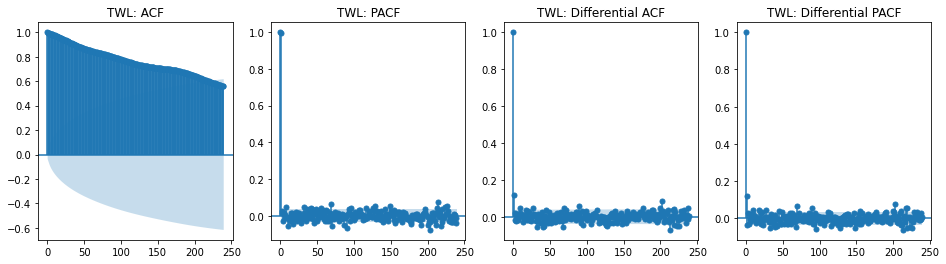

In [26]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Note:  Same is in pmdarima package via a wrapper function

columns = 4
fig, axes = plt.subplots(cnt_stocks, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*cnt_stocks) )
plt.title('ACF/PACF');

for stk in range(cnt_stocks):
    axis = axes[stk][0]
    plot_acf(data_series, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: ACF")
    
    axis = axes[stk][1]
    plot_pacf(data_series, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: PACF")
    
    axis = axes[stk][2]
    plot_acf(data_diff, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: Differential ACF")
    
    axis = axes[stk][3]
    plot_pacf(data_diff, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: Differential PACF")
    
plt.show()

As per the above plots, stationarity is observed after 1 level of differentiation. 
<br>However, there is no definite trend observed to derive p,q and P,Q values for ARIMA model

### Get rolling yearly seasonality using Seasonal decompose

<br> For daily data with yearly sesonality, m = 365.25
<br> However in our case we have @245 records per year, hence, m = @245

In [27]:
sd_modes = ['additive', 'multiplicative']
sd_algos = ['sm', 'pmd']
sd_dict = {} 
for key in sd_algos: 
    for value in sd_modes: 
        sd_dict[f'{key}_{value[0:3]}'] = value 

start_from = split_year + 1 - min_train_data_years
sd_data = data[data.year >= start_from - 1][[group_by_col]]

#Running seasonal_decompose for cross validation years        
for i in range(cross_val + min_train_data_years - 1):
    pred_year = start_from + i
    #print(pred_year)
    #y_train = data[data.year < pred_year][[agg_value_col]]
    y_train = data[data.year < pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in sd_modes:
        #seasonal_decompose using statsmodels package
        sd = seasonal_decompose(y_train, model=mode, period=freq)
        latest_year_cnt = len(data[data.year == y_train.index.year.max()])
        sd_data.loc[y_train.index[-latest_year_cnt:], f'sm_{mode[0:3]}'] = pd.Series(sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])  
        #seasonal_decompose using pmdarima package
        pmd_sd = pm.arima.decompose(y_train.values, type_=mode, m=freq, filter_=None)
        sd_data.loc[y_train.index[-latest_year_cnt:], f'pmd_{mode[0:3]}'] = pd.Series(pmd_sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])
               
sd_data.dropna()

,year,sm_add,pmd_add,sm_mul,pmd_mul
date,,,,,
2010-01-04,2010,1.453172,-4.494503,1.049533,0.872408
2010-01-05,2010,1.801312,-0.723144,1.059049,0.982506
2010-01-06,2010,1.602912,-0.375005,1.051558,0.991414
2010-01-07,2010,0.879572,-0.573405,1.027746,0.984402
2010-01-08,2010,-1.475046,-1.296745,0.952464,0.962111
...,...,...,...,...,...
2018-12-24,2018,6.805503,6.037474,1.024047,1.002356
2018-12-26,2018,5.768689,6.754919,1.002474,1.004656
2018-12-27,2018,4.970669,5.718105,0.981500,0.983491


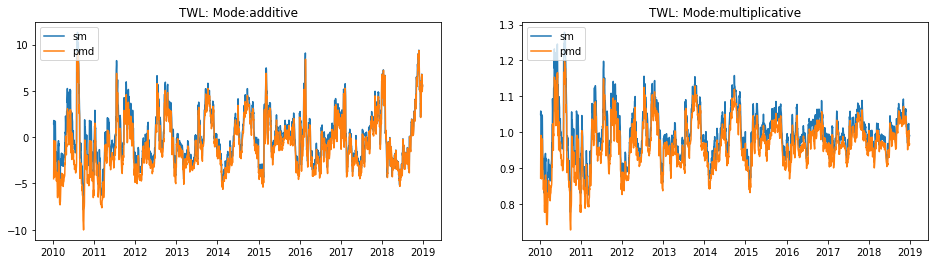

In [28]:
#Plot the Seasonal decompose output:
columns = len(sd_modes)
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Seasonal decompose output');

for stk in range(cnt_stocks):
    for m in range(columns):
        sp = axes[stk][m]
        key = f'_{sd_modes[m][0:3]}'            
        sp.plot(sd_data.filter(regex=key, axis=1))            
        sp.legend(sd_algos, loc='upper left')
        sp.set_title(f"{stock_tickers[stk]}: Mode:{sd_modes[m]}")

plt.show()

In [29]:
#Get yearwise min. price
sd_agg = sd_data.groupby(group_by_col).idxmin().dropna()
sd_agg

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2010,2010-09-24,2010-09-27,2010-09-27,2010-09-28
2011,2011-03-09,2011-03-09,2011-02-04,2011-02-04
2012,2012-01-17,2012-01-17,2012-01-17,2012-01-17
2013,2013-03-06,2013-03-07,2013-03-06,2013-03-07
2014,2014-02-18,2014-02-18,2014-02-13,2014-02-13
2015,2015-02-10,2015-02-10,2015-02-11,2015-02-11
2016,2016-06-27,2016-06-28,2016-01-27,2016-01-28
2017,2017-06-20,2017-06-20,2017-02-23,2017-02-23
2018,2018-06-11,2018-06-12,2018-02-19,2018-02-20


In [30]:
#Get working day for given dates
def get_wd(row):
    #print(row)
    ref = pd.Series(index = row.index)
    for i in range(len(row)):
        ref.loc[row.index[i]] = (wd_series[row[i]])
    #print(ref)
    return ref

#Get percentile of sma for given dates
def get_pctile(row):
    #print(row)
    ref = pd.Series(index = row.index)
    for i in range(len(row)):
        ref.loc[row.index[i]] = (pctile_series[row[i]])
    #print(ref)
    return ref

In [31]:

sd_output = sd_agg.apply(get_wd, axis = 1)
sd_output

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2010,183.0,184.0,184.0,185.0
2011,46.0,46.0,24.0,24.0
2012,12.0,12.0,12.0,12.0
2013,47.0,48.0,47.0,48.0
2014,35.0,35.0,32.0,32.0
2015,28.0,28.0,29.0,29.0
2016,120.0,121.0,18.0,19.0
2017,116.0,116.0,38.0,38.0
2018,110.0,111.0,34.0,35.0


In [32]:
#Get avg. seasonality for last 5 years w/o ignoring the outlier to show the diff. betn. with and w/o outliers
sd_rm = sd_output.rolling(min_train_data_years).mean().dropna()
#sd_refined = df * df.sub(df.rolling(5).mean()).div(df.rolling(5).std()).abs().lt(1.25)
sd_rm

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2014,64.6,65.0,59.8,60.2
2015,33.6,33.8,28.8,29.0
2016,48.4,48.8,27.6,28.0
2017,69.2,69.6,32.8,33.2
2018,81.8,82.2,30.2,30.6


In [33]:
#Get avg. seasonality for last 5 years while ignoring the outlier years
sd_refined = pd.DataFrame(columns = sd_rm.columns)
for i in range(cross_val):    
    pred_year = split_year + i
    #print(pred_year)    
    df = sd_output.loc[pred_year-5:pred_year-1]
    #print(df)
    #1.25 is the average ratio of error to deviation for marking outliers, TO - DO ignore std < 5
    #outlier_diff = 5
    #ref_df = df * df.sub(df.mean()).abs().lt(outlier_diff) - not the right way
    outlier_ratio = 1.25
    #print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
    ref_df = df * df.sub(df.mean()).div(df.std(), ).abs().lt(outlier_ratio)      
    #Replace 0 with NaN to ensure that outliers are ignored while calculating mean
    ref_df.replace(0, np.nan, inplace=True)
    #print(ref_df)
    #print(ref_df.mean())
    sd_refined = sd_refined.append(ref_df.mean(), ignore_index=True)

#Increment the year by 1 to indicate that this is the prediction for next year
sd_refined.index += split_year
#Add the actual output column - wd_min_sma
sd_refined = year_agg_data[['wd_min_sma']].join(sd_refined, how='inner')
#Rename column to indicate the correct interpretation
sd_refined.index.name = 'pred_year'
sd_refined

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,,
2015,6,35.0,35.25,28.750000,29.000000
2016,97,39.0,39.25,28.333333,28.333333
2017,46,30.5,30.75,22.750000,23.000000
2018,192,69.2,69.60,33.000000,33.000000
2019,147,81.8,82.20,33.250000,33.500000


In [34]:
#Get percentile from working day and year
def get_pctile_fron_wd(row):
    ref = row.copy()#pd.Series(index = row.index)
    #print(ref)
    year = row[0]
    #print(year)
    row = row[1:]
    #print(row)
    for i in range(len(row)):
        #print(row[i])
        ref.loc[row.index[i]] = data[(data.year == year) & (data[wd_col] == round(row[i], 0))].pctile[0]
    #print(ref)
    return ref

In [35]:
sd_pctile = sd_refined.reset_index()
sd_pctile = sd_pctile.apply(get_pctile_fron_wd, axis = 1)
sd_pctile.set_index('pred_year', inplace = True)
sd_pctile

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,,
2015.0,0.406504,78.455285,78.455285,10.162602,10.162602
2016.0,0.406504,52.032520,52.032520,89.430894,89.430894
2017.0,0.403226,7.258065,3.629032,16.532258,16.532258
2018.0,0.406504,73.170732,72.357724,86.991870,86.991870
2019.0,0.413223,53.305785,53.305785,49.173554,50.413223


## Holt Winters

In [36]:
hwes_trends = [None, 'additive', 'multiplicative']
hwes_modes = ['additive', 'multiplicative']
     
#hwes_data = data[data.year >= split_year][[group_by_col, agg_value_col, agg_value_col_sma]]
hwes_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
hwes_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) 
#hwes_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']]##Update to use year_agg_data with mean values

#Running Holt Winters forecasting for cross validation years        
for i in range(cross_val):
    pred_year = split_year + i
    #y_train = data[data.year < pred_year][[agg_value_col]]
    y_train = data[data.year < pred_year][agg_value_col]
    y_test = data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in hwes_modes:
        for trend in hwes_trends:
            #Excluding extreme scenario when both trend and seasonality are multiplicative
            if (mode != 'multiplicative' or trend != 'multiplicative' ):
                #forecasting
                #trend, seasonal: {“add”, “mul”, “additive”, “multiplicative”, None}, optional
                #initialization_method: None, ‘estimated’(Default), ‘heuristic’, ‘legacy-heuristic’, ‘known’  
                #use_boxcox{True, False, ‘log’, float}, optional
                hwes_model = HWES(y_train, seasonal_periods=freq, trend=trend, seasonal=mode).fit()            
                #print(hwes_model.summary())
                hwes_forecast = hwes_model.forecast(steps=year_agg_data.loc[pred_year, 'record_cnt'])
                #print(hwes_forecast)
                if trend is None:
                     t = 'n'
                else:
                     t = trend[0]
                hwes_data.loc[y_test.index, 
                              f'hwes_t{t}_s{mode[0]}'] = pd.Series(hwes_forecast.values, index = y_test.index) 
                #Set forecast metrics
                hwes_fcast_metrics.loc[pred_year, f'smape_hwes_t{t}_s{mode[0]}'] = smape(y_test, hwes_forecast)
                #mean_absolute_error(y_test, hwes_forecast)
                #sqrt(mean_squared_error(y_test, hwes_forecast)),
            
            #Use break to stop execution after 1 loop for debugging
            #break
        #break
    #break
        
hwes_data, hwes_fcast_metrics

(            year  adj_close  hwes_tn_sa  hwes_ta_sa  hwes_tm_sa  hwes_tn_sm  \
 date                                                                          
 2015-01-01  2015  60.701736   61.688543   60.671252   65.639311   59.367751   
 2015-01-02  2015  60.121506   60.864609   58.659258   69.026790   58.713378   
 2015-01-05  2015  61.098225   60.196174   56.852373   71.257696   57.854725   
 2015-01-06  2015  58.013336   60.087949   55.648511   72.861564   58.389654   
 2015-01-07  2015  57.839268   60.979181   55.472960   74.700156   60.504321   
 ...          ...        ...         ...         ...         ...         ...   
 2019-12-24  2019  45.099998   80.902177   85.711000   83.018449   80.562201   
 2019-12-26  2019  46.700001   80.860141   85.649583   83.213115   80.643964   
 2019-12-27  2019  46.849998   79.578548   84.382466   82.189867   79.560117   
 2019-12-30  2019  49.700001   79.978526   84.721313   82.974593   79.924633   
 2019-12-31  2019  49.099998   80.742528

As observed in HWES output, with both trend and sesonality set to multiplicative, the output shoots exponetially. Hence, ignore this case.

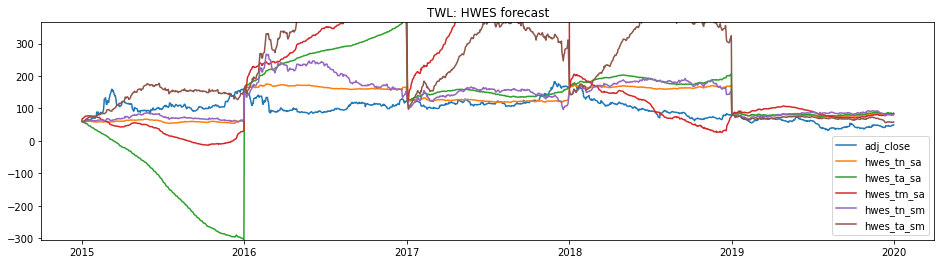

In [37]:
#Plot the HWES forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('HWES forecast output')

#Drop unwated columns from plot = year
hwes_data.drop([group_by_col], axis = 1, inplace = True)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(hwes_data) 
    #Set ylimit for better visualization
    splt.set_ylim(hwes_data.min().min(), min(data[agg_value_col].max() * 2, hwes_data.max().max()))
    splt.legend(hwes_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

plt.show()

In [38]:
smape_avg = hwes_fcast_metrics.mean().sort_values(ascending=True)
print('Holt Winters Exponential Smoothing: Best output achieved with trend:', 
      smape_avg.index[0][-4], 'and seasonality:', smape_avg.index[0][-1])
smape_avg

Holt Winters Exponential Smoothing: Best output achieved with trend: n and seasonality: a


smape_hwes_tn_sa    39.472184
smape_hwes_tn_sm    44.540047
smape_hwes_ta_sm    67.820063
smape_hwes_ta_sa    77.563790
smape_hwes_tm_sa    86.111370
dtype: float64

## Auto Arima

###### Getting value of differencing term, d and seasonal differencing term, D

In [39]:
y_data = data[agg_value_col]

##directly estimate the number of differences required
kpss_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='adf', max_d=6)
pp_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='pp', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs, pp_diffs)

print(f"Estimated differencing term, d: {n_diffs}")

##directly estimate the number of seasonal differences
ocsb_sdiffs = pm.arima.nsdiffs(y_data, m=frequency, test='ocsb', max_D=6)
ch_sdiffs = pm.arima.nsdiffs(y_data, m=frequency, test='ch', max_D=6)
n_sdiffs = max(ocsb_sdiffs, ch_sdiffs)

print(f"Estimated seasonal differencing term, D: {n_sdiffs}")

Estimated differencing term, d: 1
Estimated seasonal differencing term, D: 0


###### Auto Arima forecasting

###### Training with yearly seasonality using FourierFeaturizer
As suggested in PMD Arima documentation - For long seasonal periods, we will use FourierFeaturizer as exogenous features

In [40]:
pmd_modes = ['ff', 'ff_date'] #, 'ff_exog', 'ff_exog_date'] 
date_features = ["year","month","week","day_of_week","day_of_month","day_of_year"]
aa_fcast_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
#aa_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']] # With mean value
aa_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) # Without mean value

#FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4) #k = no. of Sin/Cos terms - columns = k*2
y_prime, ff_data = trans.fit_transform(data[agg_value_col], exogenous=data[date_features])

#Running AutoARIMA forecasting for cross validation years
for i in range(cross_val):
    pred_year = split_year + i
    train_data = data[data.year < pred_year][[agg_value_col] + date_features]
    y_train = train_data[agg_value_col]
    test_data = data[data.year == pred_year][[agg_value_col] + date_features]
    y_test = test_data[agg_value_col] #data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    train_ff_data = ff_data[ff_data.year < pred_year]
    test_ff_data = ff_data[ff_data.year == pred_year]
    
    train_exog = None
    test_exog = None
    for mode in pmd_modes:
        if (mode == pmd_modes[0]):
            train_exog = train_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
            test_exog = test_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
        else:
            train_exog = train_ff_data.copy()
            test_exog = test_ff_data.copy()
            
        #forecasting
        aa_model = pm.auto_arima(y_train, exogenous=train_exog, d=n_diffs, max_p=6, 
                         seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
        print('AutoArima Model order:', aa_model.order)
        #print(aa_model.summary())
        #aa_fcast, conf_int = aa_model.predict(n_periods=len(y_test), exogenous=test_exog, return_conf_int=True)
        aa_fcast = aa_model.predict(n_periods=len(y_test), exogenous=test_exog, return_conf_int=False)
        #print(aa_fcast)
        aa_fcast_data.loc[y_test.index, f'aa_{mode}'] = pd.Series(aa_fcast, index = y_test.index) 
        #Derive forecast metrics
        aa_fcast_metrics.loc[pred_year, f'smape_aa_{mode}'] = smape(y_test, aa_fcast)
        print('Forecasting completed for', pred_year, 'mode:', mode, 'using ARIMA order:', aa_model.order)
        #Use break to stop execution after 1 loop for debugging
        #break        
    #break
        
aa_fcast_data, aa_fcast_metrics

AutoArima Model order: (3, 1, 3)
Forecasting completed for 2015 mode: ff using ARIMA order: (3, 1, 3)
AutoArima Model order: (1, 1, 0)
Forecasting completed for 2015 mode: ff_date using ARIMA order: (1, 1, 0)
AutoArima Model order: (0, 1, 1)
Forecasting completed for 2016 mode: ff using ARIMA order: (0, 1, 1)
AutoArima Model order: (0, 1, 1)
Forecasting completed for 2016 mode: ff_date using ARIMA order: (0, 1, 1)
AutoArima Model order: (1, 1, 1)
Forecasting completed for 2017 mode: ff using ARIMA order: (1, 1, 1)
AutoArima Model order: (1, 1, 1)
Forecasting completed for 2017 mode: ff_date using ARIMA order: (1, 1, 1)
AutoArima Model order: (1, 1, 1)
Forecasting completed for 2018 mode: ff using ARIMA order: (1, 1, 1)
AutoArima Model order: (1, 1, 1)
Forecasting completed for 2018 mode: ff_date using ARIMA order: (1, 1, 1)
AutoArima Model order: (3, 1, 2)
Forecasting completed for 2019 mode: ff using ARIMA order: (3, 1, 2)
AutoArima Model order: (1, 1, 1)
Forecasting completed for 201

(            year  adj_close      aa_ff  aa_ff_date
 date                                              
 2015-01-01  2015  60.701736  60.831645   62.353975
 2015-01-02  2015  60.121506  60.984181   62.040033
 2015-01-05  2015  61.098225  60.361945   61.849982
 2015-01-06  2015  58.013336  60.503900   61.495363
 2015-01-07  2015  57.839268  59.898660   61.146953
 ...          ...        ...        ...         ...
 2019-12-24  2019  45.099998  81.103985   93.897379
 2019-12-26  2019  46.700001  81.171482   93.980084
 2019-12-27  2019  46.849998  81.233163   94.046315
 2019-12-30  2019  49.700001  81.288649   94.297045
 2019-12-31  2019  49.099998  81.337298   94.351852
 
 [1228 rows x 4 columns],
       smape_aa_ff  smape_aa_ff_date
 2015    45.596265         41.810023
 2016    43.728799         54.081557
 2017    10.640114         12.962073
 2018    50.341600         56.142752
 2019    34.928495         42.812065)

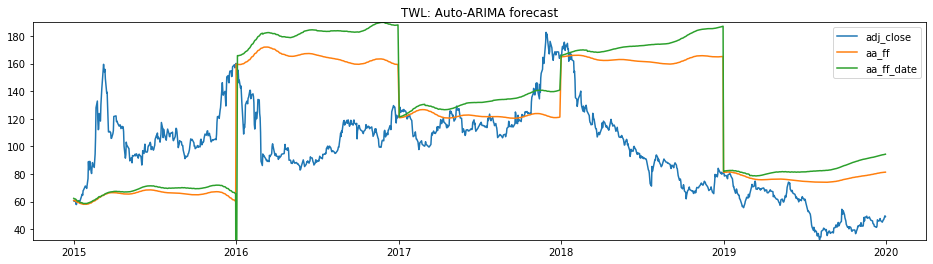

In [41]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Auto-ARIMA with FourierFeaturizer forecast output')

#Drop unwated columns from plot = year
aa_fcast_data.drop([group_by_col], axis = 1, inplace = True)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(aa_fcast_data) 
    #Set ylimit for better visualization
    splt.set_ylim(aa_fcast_data[agg_value_col].min(), min(data[agg_value_col].max() * 2, aa_fcast_data.max().max()))
    splt.legend(aa_fcast_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

plt.show()

In [42]:
aa_smape_avg = aa_fcast_metrics.mean().sort_values(ascending=True)
print('Auto-ARIMA with FourierFeaturizer - Best output achieved with:', aa_smape_avg.index[0])
aa_smape_avg

Auto-ARIMA with FourierFeaturizer - Best output achieved with: smape_aa_ff


smape_aa_ff         37.047055
smape_aa_ff_date    41.561694
dtype: float64

As observed in above plot and metrics, there is a significant improvement on adding exogenous features even with same data and model paramters

## Facebook Prophet

In [43]:
#Setting up dataset as per fbprophet requirements
pdata = pd.DataFrame() 
pdata['ds'] = data.index
pdata['y'] = data[agg_value_col].values

#Required for growth = "logistic"
pdata['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata

,ds,y,cap
0,2008-04-21,12.733235,274.002708
1,2008-04-22,60.442093,274.002708
2,2008-04-23,63.995399,274.002708
3,2008-04-24,61.766136,274.002708
4,2008-04-25,60.514153,274.002708
...,...,...,...
2863,2019-12-24,45.099998,274.002708
2864,2019-12-26,46.700001,274.002708
2865,2019-12-27,46.849998,274.002708
2866,2019-12-30,49.700001,274.002708


In [44]:
#growth = "linear" or "logistic" to specify a linear or logistic trend.
#yearly.seasonality, weekly.seasonality, daily.seasonality  = "auto", TRUE, FALSE or a number of Fourier terms to generate.
#seasonality_mode = "additive" (default) or "multiplicative"
fb_growth = ['linear', 'logistic']
fb_smodes = ['additive', 'multiplicative']
     
fb_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
fb_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) ##years w/o mean values
#fb_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']] ##years with mean values

#Running Prophet forecasting for cross validation years        
for i in range(cross_val):
    pred_year = split_year + i
    
    y_train = pdata[pdata.ds.dt.year < pred_year] 
    y_test = pdata[pdata.ds.dt.year == pred_year]  
    #y_train = data[data.year < pred_year][agg_value_col]
    #y_test = data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.ds.dt.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in fb_smodes:
        for trend in fb_growth:
            t = trend[0:3]
            m = mode[0:3]
            fb_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, growth=trend, seasonality_mode=mode)
            fb_model.fit(y_train)
            fb_fcast = fb_model.predict(y_test)
            fb_data.loc[y_test.ds, f'fbp_{t}_{m}'] = pd.Series(fb_fcast.yhat.values, index = y_test.ds) 
            fb_data.loc[y_test.ds, f'fbp_yearly_{t}_{m}'] = pd.Series(fb_fcast.yearly.values, index = y_test.ds) 
            #Capture prediction metrics
            fb_fcast_metrics.loc[pred_year, f'smape_fbp_{t}_{m}'] = smape(y_test.y, fb_fcast.yhat)
            #mean_absolute_error(y_test.y, fb_fcast.yhat)
            #sqrt(mean_squared_error(y_test.y, fb_fcast.yhat))
            
            #Use break to stop execution after 1 loop for debugging
            #break
        #break
    #break
        
fb_data, fb_fcast_metrics

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

(            year  adj_close  fbp_lin_add  fbp_yearly_lin_add  fbp_log_add  \
 date                                                                        
 2015-01-01  2015  60.701736    58.523996            4.521958    52.847229   
 2015-01-02  2015  60.121506    58.673857            4.586630    52.930705   
 2015-01-05  2015  61.098225    59.027900            4.685107    53.064855   
 2015-01-06  2015  58.013336    59.109347            4.681366    53.067785   
 2015-01-07  2015  57.839268    59.170880            4.657709    53.049197   
 ...          ...        ...          ...                 ...          ...   
 2019-12-24  2019  45.099998    99.867517           10.021060   104.911211   
 2019-12-26  2019  46.700001   100.377712           10.583395   105.510976   
 2019-12-27  2019  46.849998   100.615549           10.847302   105.787103   
 2019-12-30  2019  49.700001   101.223519           11.533484   106.473400   
 2019-12-31  2019  49.099998   101.381615           11.717651   

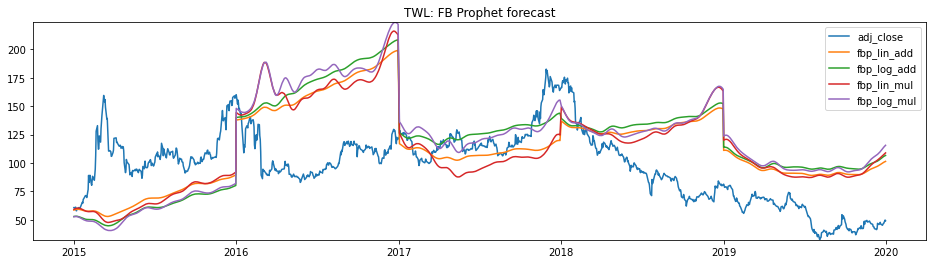

In [45]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('FB Prophet forecast output')

#Drop unwated columns from plot = year
fb_fcast_data = fb_data.drop(fb_data.filter(regex='year').columns, axis = 1)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(fb_fcast_data) 
    #Set ylimit for better visualization
    splt.set_ylim(fb_fcast_data.min().min(), min(data[agg_value_col].max() * 2, fb_fcast_data.max().max()))
    splt.legend(fb_fcast_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: FB Prophet forecast")

plt.show()

In [46]:
fb_smape_avg = fb_fcast_metrics.mean().sort_values(ascending=True)
print('FB Prophet - Best output achieved with:', fb_smape_avg.index[0])
fb_smape_avg

FB Prophet - Best output achieved with: smape_fbp_lin_add


smape_fbp_lin_add    37.013173
smape_fbp_lin_mul    39.179946
smape_fbp_log_add    41.101543
smape_fbp_log_mul    41.521051
dtype: float64

With all combinations, there is always as degradation observed with seasonality_mode = "multiplicative"

In [47]:
fcast_metrics = pd.concat([hwes_fcast_metrics, aa_fcast_metrics, fb_fcast_metrics], axis=1)
fcast_metrics

,smape_hwes_tn_sa,smape_hwes_ta_sa,smape_hwes_tm_sa,smape_hwes_tn_sm,smape_hwes_ta_sm,smape_aa_ff,smape_aa_ff_date,smape_fbp_lin_add,smape_fbp_log_add,smape_fbp_lin_mul,smape_fbp_log_mul
2015,53.250648,178.634694,121.604541,39.054331,30.690848,45.596265,41.810023,40.293000,52.171801,43.191851,52.976636
2016,44.092306,86.684494,103.281838,60.217095,110.067966,43.728799,54.081557,43.830024,48.146462,46.041021,50.999501
2017,11.308730,20.191392,127.691813,24.962454,74.325605,10.640114,12.962073,12.555919,10.067028,18.544740,9.716681
2018,51.413128,62.252141,31.968587,57.260645,97.843326,50.341600,56.142752,34.251103,36.838427,33.068930,34.678407
2019,37.296108,40.056231,46.010071,41.205708,26.172568,34.928495,42.812065,54.135820,58.283997,55.053186,59.234032


In [48]:
smape_avg = fcast_metrics.mean().sort_values(ascending=True)
print('Best price forecast output achieved with:', smape_avg.index[0])
smape_avg

Best price forecast output achieved with: smape_fbp_lin_add


smape_fbp_lin_add    37.013173
smape_aa_ff          37.047055
smape_fbp_lin_mul    39.179946
smape_hwes_tn_sa     39.472184
smape_fbp_log_add    41.101543
smape_fbp_log_mul    41.521051
smape_aa_ff_date     41.561694
smape_hwes_tn_sm     44.540047
smape_hwes_ta_sm     67.820063
smape_hwes_ta_sa     77.563790
smape_hwes_tm_sa     86.111370
dtype: float64

Based on above results, best models for different algorithms are as follows:
<ul>
    <li>HWES: trend=None, seasonality mode ='add'</li>
    <li>AutoArima: Fourier Featurizer with date parts as exogenous features</li>
    <li>Prophet: yearly seasonality, logistic growth, seasonality mode ='add'</li>
</ul>

### Derive the best time of the year to invest based on price forecast

In [49]:
fcast_data = hwes_data.drop([agg_value_col]
                           , axis = 1).join(aa_fcast_data.drop([agg_value_col]
                                                               , axis = 1)).join(fb_data.drop([agg_value_col, group_by_col]
                                                                                              , axis = 1))
fcast_data

,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
date,,,,,,,,,,,,,,,
2015-01-01,61.688543,60.671252,65.639311,59.367751,59.628133,60.831645,62.353975,58.523996,4.521958,52.847229,4.562048,59.148894,0.123471,52.624901,0.100588
2015-01-02,60.864609,58.659258,69.026790,58.713378,59.249575,60.984181,62.040033,58.673857,4.586630,52.930705,4.582284,59.349262,0.125552,52.709253,0.100930
2015-01-05,60.196174,56.852373,71.257696,57.854725,58.804714,60.361945,61.849982,59.027900,4.685107,53.064855,4.526325,59.863178,0.130111,52.839874,0.099396
2015-01-06,60.087949,55.648511,72.861564,58.389654,59.882957,60.503900,61.495363,59.109347,4.681366,53.067785,4.465755,59.995119,0.130879,52.837273,0.097926
2015-01-07,60.979181,55.472960,74.700156,60.504321,62.691931,59.898660,61.146953,59.170880,4.657709,53.049197,4.383603,60.102947,0.131191,52.809926,0.095944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,80.902177,85.711000,83.018449,80.562201,58.224382,81.103985,93.897379,99.867517,10.021060,104.911211,9.437524,106.414613,0.167557,112.424416,0.160436
2019-12-26,80.860141,85.649583,83.213115,80.643964,58.244408,81.171482,93.980084,100.377712,10.583395,105.510976,10.074993,107.181353,0.176611,113.418733,0.171119
2019-12-27,79.578548,84.382466,82.189867,79.560117,57.239780,81.233163,94.046315,100.615549,10.847302,105.787103,10.369970,107.552000,0.181002,113.897791,0.176277


In [50]:
fcast_data.groupby([fcast_data.index.year]).idxmin().apply(get_wd, axis = 1)

,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
date,,,,,,,,,,,,,,,
2015,134.0,246.0,193.0,3.0,3.0,19.0,20.0,51.0,55.0,53.0,56.0,53.0,55.0,55.0,58.0
2016,221.0,1.0,1.0,4.0,4.0,245.0,1.0,1.0,85.0,1.0,61.0,8.0,203.0,13.0,205.0
2017,136.0,2.0,1.0,3.0,3.0,177.0,1.0,88.0,89.0,62.0,62.0,90.0,90.0,90.0,91.0
2018,152.0,1.0,232.0,3.0,5.0,167.0,1.0,90.0,92.0,60.0,61.0,103.0,105.0,97.0,99.0
2019,133.0,133.0,184.0,30.0,231.0,152.0,52.0,134.0,133.0,159.0,61.0,130.0,106.0,187.0,132.0


In [51]:
wd_min_fcast = sd_refined.join(fcast_data.groupby([fcast_data.index.year]).idxmin().apply(get_wd, axis = 1))
wd_min_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,6,35.0,35.25,28.750000,29.000000,134.0,246.0,193.0,3.0,3.0,19.0,20.0,51.0,55.0,53.0,56.0,53.0,55.0,55.0,58.0
2016,97,39.0,39.25,28.333333,28.333333,221.0,1.0,1.0,4.0,4.0,245.0,1.0,1.0,85.0,1.0,61.0,8.0,203.0,13.0,205.0
2017,46,30.5,30.75,22.750000,23.000000,136.0,2.0,1.0,3.0,3.0,177.0,1.0,88.0,89.0,62.0,62.0,90.0,90.0,90.0,91.0
2018,192,69.2,69.60,33.000000,33.000000,152.0,1.0,232.0,3.0,5.0,167.0,1.0,90.0,92.0,60.0,61.0,103.0,105.0,97.0,99.0
2019,147,81.8,82.20,33.250000,33.500000,133.0,133.0,184.0,30.0,231.0,152.0,52.0,134.0,133.0,159.0,61.0,130.0,106.0,187.0,132.0


In [52]:
output_mae = wd_min_fcast.apply(lambda x : abs(x - x['wd_min_sma']), axis=1).drop('wd_min_sma', axis = 1)
output_mae 

,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,
2015,29.0,29.25,22.750000,23.000000,128.0,240.0,187.0,3.0,3.0,13.0,14.0,45.0,49.0,47.0,50.0,47.0,49.0,49.0,52.0
2016,58.0,57.75,68.666667,68.666667,124.0,96.0,96.0,93.0,93.0,148.0,96.0,96.0,12.0,96.0,36.0,89.0,106.0,84.0,108.0
2017,15.5,15.25,23.250000,23.000000,90.0,44.0,45.0,43.0,43.0,131.0,45.0,42.0,43.0,16.0,16.0,44.0,44.0,44.0,45.0
2018,122.8,122.40,159.000000,159.000000,40.0,191.0,40.0,189.0,187.0,25.0,191.0,102.0,100.0,132.0,131.0,89.0,87.0,95.0,93.0
2019,65.2,64.80,113.750000,113.500000,14.0,14.0,37.0,117.0,84.0,5.0,95.0,13.0,14.0,12.0,86.0,17.0,41.0,40.0,15.0


In [53]:
best_mae = output_mae[-1:].transpose().sort_values(by=current_year-1, ascending=True)
best_mae #[:5]

pred_year,2019
aa_ff,5.00
fbp_log_add,12.00
fbp_lin_add,13.00
fbp_yearly_lin_add,14.00
hwes_tn_sa,14.00
hwes_ta_sa,14.00
fbp_yearly_log_mul,15.00
fbp_lin_mul,17.00
hwes_tm_sa,37.00
fbp_log_mul,40.00


In [54]:
print('Top 5 best sesonality forecast for 2019 for', stock_ticker, ':\n', best_mae.index[0:5])

Top 5 best sesonality forecast for 2019 for TWL :
 Index(['aa_ff', 'fbp_log_add', 'fbp_lin_add', 'fbp_yearly_lin_add',
       'hwes_tn_sa'],
      dtype='object')


Top models for each technique:
<ol>
    <li>FB Prophet yearly pattern (Seasonality: Additive): <font color="red">0 days</font></li>
    <li>FB Prophet (Seasonality: Multiplicative): <font color="red">1 day</font></li>
    <li>AutoArima (using Fourier Featurizer): <font color="red">1 day</font></li>
    <li>HWES (Seasonality: Additive): <font color="red">4 days</font></li>
    <li>Seasonal decompose (Seasonality: Additive): <font color="red">6.4 days</font></li>
</ol>

In [55]:
#Threshold for accuracy = 10 days
threshold = 15
output_mae.loc[:, output_mae[output_mae <= threshold].count() >= 3]

""
pred_year
2015
2016
2017
2018
2019


In [56]:
accurate_mae = output_mae[ output_mae <= threshold ].count()
consistent = accurate_mae[accurate_mae > 2].sort_values(ascending = False)

In [57]:
print('Algorithms with most accurate forecast for last 5 years', stock_ticker, ':\n', consistent[0:3])

Algorithms with most accurate forecast for last 5 years TWL :
 Series([], dtype: int64)


### Accuracy based on Percentile of price 

In [58]:
wd_min_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,6,35.0,35.25,28.750000,29.000000,134.0,246.0,193.0,3.0,3.0,19.0,20.0,51.0,55.0,53.0,56.0,53.0,55.0,55.0,58.0
2016,97,39.0,39.25,28.333333,28.333333,221.0,1.0,1.0,4.0,4.0,245.0,1.0,1.0,85.0,1.0,61.0,8.0,203.0,13.0,205.0
2017,46,30.5,30.75,22.750000,23.000000,136.0,2.0,1.0,3.0,3.0,177.0,1.0,88.0,89.0,62.0,62.0,90.0,90.0,90.0,91.0
2018,192,69.2,69.60,33.000000,33.000000,152.0,1.0,232.0,3.0,5.0,167.0,1.0,90.0,92.0,60.0,61.0,103.0,105.0,97.0,99.0
2019,147,81.8,82.20,33.250000,33.500000,133.0,133.0,184.0,30.0,231.0,152.0,52.0,134.0,133.0,159.0,61.0,130.0,106.0,187.0,132.0


In [59]:
fcast_pctile = wd_min_fcast.reset_index()
fcast_pctile = fcast_pctile.apply(get_pctile_fron_wd, axis = 1)
fcast_pctile.set_index('pred_year', inplace = True)
fcast_pctile

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015.0,0.406504,78.455285,78.455285,10.162602,10.162602,70.325203,99.186992,41.463415,1.626016,1.626016,7.723577,8.130081,87.804878,74.796748,84.552846,68.699187,84.552846,74.796748,74.796748,62.195122
2016.0,0.406504,52.032520,52.032520,89.430894,89.430894,51.626016,100.000000,100.000000,98.780488,98.780488,83.739837,100.000000,100.000000,10.162602,100.000000,30.081301,97.154472,67.073171,73.170732,61.382114
2017.0,0.403226,7.258065,3.629032,16.532258,16.532258,47.983871,74.193548,70.564516,76.612903,76.612903,49.193548,70.564516,79.838710,81.048387,34.274194,34.274194,80.645161,80.645161,80.645161,77.419355
2018.0,0.406504,73.170732,72.357724,86.991870,86.991870,44.715447,94.715447,10.975610,96.341463,99.186992,37.398374,94.715447,63.821138,63.414634,67.886179,68.699187,58.536585,55.284553,59.349593,60.162602
2019.0,0.413223,53.305785,53.305785,49.173554,50.413223,33.057851,33.057851,32.644628,50.826446,30.165289,14.049587,88.842975,28.099174,33.057851,5.371901,84.297521,46.280992,71.074380,19.834711,40.909091


In [60]:
#Check to see if Predicted min. work day price was actually in lower 20 percentile of the yearly price variations
pctile_threshold = 20
fcast_pctile.copy().apply(lambda x : x < pctile_threshold)
accurate_fcast = wd_min_fcast * fcast_pctile.copy().apply(lambda x : x < pctile_threshold)
accurate_fcast.replace(0, np.nan, inplace = True)
accurate_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,6,NaN,NaN,28.75,29.0,NaN,NaN,NaN,3.0,3.0,19.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN
2017,46,30.5,30.75,22.75,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,192,NaN,NaN,NaN,NaN,NaN,NaN,232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN,NaN,NaN,159.0,NaN,NaN,NaN,187.0,NaN


In [61]:
#Check to see if Predicted min. work day price was actually in lower 20 percentile of the yearly price variations
pctile_threshold = 20
wd_min_fcast.loc[:, fcast_pctile[fcast_pctile <= pctile_threshold].count() >= 3]

,wd_min_sma
pred_year,
2015,6
2016,97
2017,46
2018,192
2019,147


In [62]:
fcast_pctile[fcast_pctile <= pctile_threshold]

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015.0,0.406504,NaN,NaN,10.162602,10.162602,NaN,NaN,NaN,1.626016,1.626016,7.723577,8.130081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016.0,0.406504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.162602,NaN,NaN,NaN,NaN,NaN,NaN
2017.0,0.403226,7.258065,3.629032,16.532258,16.532258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018.0,0.406504,NaN,NaN,NaN,NaN,NaN,NaN,10.97561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019.0,0.413223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.049587,NaN,NaN,NaN,5.371901,NaN,NaN,NaN,19.834711,NaN


In [63]:
top_algos = fcast_pctile[fcast_pctile <= pctile_threshold].count()[1:].sort_values(ascending = False)
top_algos

aa_ff                 2
sm_mul                2
pmd_mul               2
fbp_log_mul           1
pmd_add               1
hwes_tm_sa            1
hwes_tn_sm            1
hwes_ta_sm            1
sm_add                1
aa_ff_date            1
fbp_yearly_lin_add    1
fbp_log_add           1
fbp_lin_add           0
hwes_ta_sa            0
hwes_tn_sa            0
fbp_yearly_log_add    0
fbp_lin_mul           0
fbp_yearly_lin_mul    0
fbp_yearly_log_mul    0
dtype: int64

In [64]:
print('Best results for', stock_ticker, 'stock with each of the 5 algorithms are as follows:')
print('Method: ', top_algos.filter(regex='^hwes_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^hwes_')[0])
print('Method: ', top_algos.filter(regex='^aa_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^aa_')[0])
print('Method: ', top_algos.filter(regex='^fbp_l').index[0], 'Correct predicted years: ', top_algos.filter(regex='^fbp_l')[0])
print('Method: ', top_algos.filter(regex='^fbp_y').index[0], 'Correct predicted years: ', top_algos.filter(regex='^fbp_y')[0])
print('Method: ', top_algos.filter(regex='^sm_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^sm_')[0])

Best results for TWL stock with each of the 5 algorithms are as follows:
Method:  hwes_tm_sa Correct predicted years:  1
Method:  aa_ff Correct predicted years:  2
Method:  fbp_log_mul Correct predicted years:  1
Method:  fbp_yearly_lin_add Correct predicted years:  1
Method:  sm_mul Correct predicted years:  2


In [65]:
end = time.time()
print('Analyzing data took ' + str(round((end - start), 3)) + ' seconds for ' + stock_ticker + '.')  

Analyzing data took 1776.35 seconds for TWL.


### Prediction for current year
Using top 5 best models

In [66]:
y_train = data[agg_value_col]
train_years = len(y_train.index.year.unique())
freq = int(round((len(y_train) / train_years), 0))

##### Generate current year data set

In [67]:
trading_holidays = ['2020-02-21', '2020-03-10', '2020-04-02', '2020-04-06', '2020-04-10', '2020-04-14'
                    , '2020-05-01', '2020-05-25', '2020-10-02', '2020-11-16', '2020-11-30', '2020-12-25'] 
pred_dates = pd.date_range(datetime.datetime(current_year, 1, 1), 
                           datetime.datetime(current_year, 12, 31), 
                           freq=pd.tseries.offsets.BDay()).to_frame(index=False, name = 'ds')
pred_dates = pred_dates[~pred_dates.ds.isin(trading_holidays)]
print('No. of working days in', current_year, ':', len(pred_dates))
pred_dates.reset_index(drop = True, inplace = True)
pred_dates.index += 1
pred_dates.index.names = ['work_doy']
pred_dates

No. of working days in 2020 : 250


,ds
work_doy,
1,2020-01-01
2,2020-01-02
3,2020-01-03
4,2020-01-06
5,2020-01-07
...,...
246,2020-12-24
247,2020-12-28
248,2020-12-29


##### Using Seasonal Decompose

In [68]:
sd_pred_data = data[data.year >= split_year][[group_by_col]]

#Running seasonal_decompose for cross validation years        
for i in range(min_train_data_years):
    till_year = split_year + i
    #print(till_year)
    #y_train = data[data.year <= till_year][[agg_value_col]]
    y_train = data[data.year <= till_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in sd_modes:
        #seasonal_decompose using statsmodels package
        sd = seasonal_decompose(y_train, model=mode, period=freq)
        latest_year_cnt = len(data[data.year == y_train.index.year.max()])
        sd_pred_data.loc[y_train.index[-latest_year_cnt:], f'sm_{mode[0:3]}'] = pd.Series(sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])  
        #seasonal_decompose using pmdarima package
        pmd_sd = pm.arima.decompose(y_train.values, type_=mode, m=freq, filter_=None)
        sd_pred_data.loc[y_train.index[-latest_year_cnt:], f'pmd_{mode[0:3]}'] = pd.Series(pmd_sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])
               
sd_pred_data.dropna()

,year,sm_add,pmd_add,sm_mul,pmd_mul
date,,,,,
2015-01-01,2015,-3.277026,-3.859860,0.933926,0.905326
2015-01-02,2015,-3.179694,-3.762119,0.939753,0.910992
2015-01-05,2015,-3.012846,-3.596088,0.944117,0.915177
2015-01-06,2015,-3.777337,-4.360444,0.927784,0.899317
2015-01-07,2015,-3.980666,-4.563038,0.922520,0.894166
...,...,...,...,...,...
2019-12-24,2019,5.832923,5.212351,0.995275,0.976400
2019-12-26,2019,5.802049,5.745421,1.001289,0.978513
2019-12-27,2019,4.719257,5.714546,0.979565,0.984425


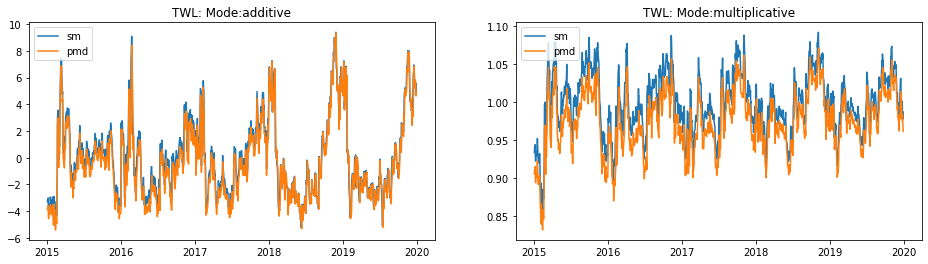

In [69]:
#Plot the Seasonal decompose output:
columns = len(sd_modes)
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Seasonal decompose output');

for stk in range(cnt_stocks):
    for m in range(columns):
        sp = axes[stk][m]
        key = f'_{sd_modes[m][0:3]}'            
        sp.plot(sd_pred_data.filter(regex=key, axis=1))            
        sp.legend(sd_algos, loc='upper left')
        sp.set_title(f"{stock_tickers[stk]}: Mode:{sd_modes[m]}")

plt.show()

In [70]:
#Get yearwise min. price
sd_pred_agg = sd_pred_data.groupby(group_by_col).idxmin().dropna().apply(get_wd, axis = 1)
sd_pred_agg

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2015,28.0,28.0,29.0,29.0
2016,120.0,121.0,18.0,19.0
2017,116.0,116.0,38.0,38.0
2018,110.0,111.0,34.0,35.0
2019,133.0,134.0,27.0,28.0


In [71]:
#Get avg. seasonality for last 5 years w/o ignoring the outlier to show the diff. betn. with and w/o outliers
sd_pred_agg.mean()

sm_add     101.4
pmd_add    102.0
sm_mul      29.2
pmd_mul     29.8
dtype: float64

In [72]:
#Get avg. seasonality for last 5 years while ignoring the outlier years
sd_pred_ref = pd.DataFrame(index = [current_year], columns = sd_pred_agg.columns)
df = sd_pred_agg.copy()
#1.25 is the average ratio of error to deviation for marking outliers
outlier_ratio = 1.25
#print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
#Doesn't matter even if some values are dropped in case of lower std below 5
ref_df = df * df.sub(df.mean()).div(df.std()).abs().lt(outlier_ratio)     
   
#Replace 0 with NaN to ensure that outliers are ignored while calculating mean
ref_df.replace(0, np.nan, inplace=True)
#print(ref_df)
#print(ref_df.mean())
sd_pred_ref.loc[current_year] = round(ref_df.mean(), 0)

#Rename column to indicate the correct interpretation
sd_pred_ref.index.name = 'pred_year'
sd_pred_ref

,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,
2020,120,120,32,32


##### Using HWES

In [73]:
pred_data = pred_dates.copy()

y_train = data[agg_value_col]
train_years = len(y_train.index.year.unique())
freq = int(round((len(y_train) / train_years), 0))

In [74]:
for mode in hwes_modes:
    for trend in hwes_trends:
        #Excluding extreme scenario when both trend and seasonality are multiplicative
        if (mode != 'multiplicative' or trend != 'multiplicative' ):
            hwes_model = HWES(y_train, seasonal_periods=freq, trend=trend, seasonal=mode).fit()            
            #print(hwes_model.summary())
            hwes_forecast = hwes_model.forecast(steps=len(pred_data))
            #print(hwes_forecast)
            if trend is None:
                 t = 'n'
            else:
                 t = trend[0]
            pred_data.loc[pred_data.index, 
                          f'hwes_t{t}_s{mode[0]}'] = pd.Series(hwes_forecast.values, index = pred_data.index) 
        #Use break to stop execution after 1 loop for debugging
        #break
    #break
        
pred_data

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm
work_doy,,,,,,
1,2020-01-01,50.062483,50.446180,50.428885,49.523405,49.760626
2,2020-01-02,54.578702,55.053279,55.458361,48.015878,48.541453
3,2020-01-03,53.845858,54.520010,55.009210,46.165355,46.861091
4,2020-01-06,51.402031,52.354840,52.840803,44.610395,45.304972
5,2020-01-07,51.703170,52.963486,53.557973,45.489792,46.101738
...,...,...,...,...,...,...
246,2020-12-24,52.675348,43.531693,52.528447,46.143677,50.322183
247,2020-12-28,53.560000,44.608181,53.982906,46.469680,50.463682
248,2020-12-29,54.417307,45.705051,55.218976,47.199846,50.996772


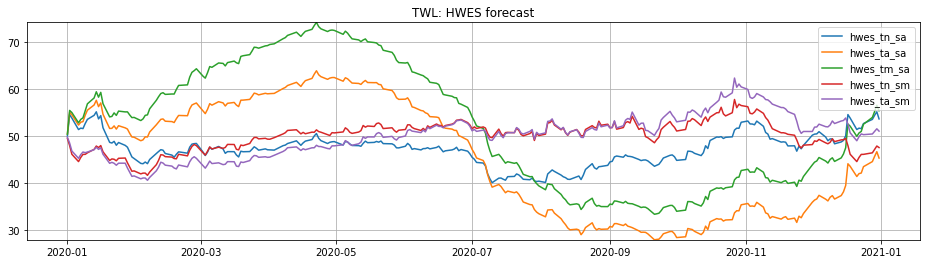

In [75]:
#Plot the HWES forecast output:
columns = 1
rows = 1
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('HWES forecast output')

#Drop unwated columns from plot = year
hwes_plot = pred_data.drop(['ds'], axis = 1)

splt = axes[0][0]                    
splt.plot(pred_data['ds'], hwes_plot) 
splt.grid(True)
#Set ylimit for better visualization
splt.set_ylim(hwes_plot.min().min(), min(data[agg_value_col].max() * 2, hwes_plot.max().max()))
splt.legend(hwes_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

plt.show()

##### Using AutoArima

In [76]:
ff_data.tail()

,year,month,week,day_of_week,day_of_month,day_of_year,FOURIER_S239-0,FOURIER_C239-0,FOURIER_S239-1,FOURIER_C239-1,FOURIER_S239-2,FOURIER_C239-2,FOURIER_S239-3,FOURIER_C239-3
2863,2019,12,52,1,24,358,-1.049651e-01,0.994476,-0.208771,0.977965,-0.310270,0.950649,-0.408341,0.912830
2864,2019,12,52,3,26,360,-7.878763e-02,0.996891,-0.157085,0.987585,-0.234407,0.972139,-0.310270,0.950648
2865,2019,12,52,4,27,361,-5.255567e-02,0.998618,-0.104966,0.994476,-0.157086,0.987585,-0.208772,0.977964
2866,2019,12,53,0,30,364,-2.628739e-02,0.999654,-0.052557,0.998618,-0.078790,0.996891,-0.104968,0.994476
2867,2019,12,53,1,31,365,-9.416902e-07,1.000000,-0.000002,1.000000,-0.000003,1.000000,-0.000004,1.000000


In [77]:
#date_features = ["year","month","week","day_of_week","day_of_month","day_of_year"]
future_algo = 'hwes_tn_sa' #Any of the other algorithm outputs as exogenous input for ARIMAX
exog_data = pred_dates.copy()
#exog_data.reset_index(inplace = True) #Uncomment if work day is required
exog_data.set_index('ds', inplace = True)
exog_data['year'] = exog_data.index.year
exog_data["month"] = exog_data.index.month
exog_data['week'] = pd.Int64Index(exog_data.index.isocalendar().week) #Deprecated - rawdf.index.week/weekofyear
exog_data["day_of_week"] = exog_data.index.dayofweek
exog_data["day_of_month"] = exog_data.index.day
exog_data['day_of_year'] = exog_data.index.dayofyear
#Handle ISO week format for last days of year marked as Week 1
exog_data.loc[(exog_data['week'] == 1) & (exog_data['day_of_year'] > 350),'week'] = 53 
#print(exog_data)

#FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4) #k = no. of Sin/Cos terms - columns = k*2
y_future, future_ff_data = trans.fit_transform(pred_data[future_algo], exogenous=exog_data[date_features])

future_ff_data

,year,month,week,day_of_week,day_of_month,day_of_year,FOURIER_S239-0,FOURIER_C239-0,FOURIER_S239-1,FOURIER_C239-1,FOURIER_S239-2,FOURIER_C239-2,FOURIER_S239-3,FOURIER_C239-3
0,2020,1,1,2,1,1,0.026286,0.999654,0.052555,0.998618,0.078787,0.996891,0.104964,0.994476
1,2020,1,1,3,2,2,0.052555,0.998618,0.104964,0.994476,0.157084,0.987585,0.208769,0.977965
2,2020,1,1,4,3,3,0.078787,0.996891,0.157084,0.987585,0.234404,0.972139,0.310267,0.950650
3,2020,1,2,0,6,6,0.104964,0.994476,0.208769,0.977965,0.310267,0.950650,0.408337,0.912831
4,2020,1,2,1,7,7,0.131069,0.991373,0.259877,0.965642,0.384201,0.923250,0.501896,0.864928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020,12,52,3,24,359,0.182989,0.983115,0.359799,0.933030,0.524458,0.851436,0.671407,0.741089
246,2020,12,53,0,28,363,0.208769,0.977965,0.408337,0.912831,0.589910,0.807469,0.745486,0.666522
247,2020,12,53,1,29,364,0.234404,0.972139,0.455746,0.890110,0.651694,0.758482,0.811328,0.584591
248,2020,12,53,2,30,365,0.259877,0.965642,0.501896,0.864928,0.709426,0.704779,0.868208,0.496201


In [78]:
train_exog = None
test_exog = None
for mode in pmd_modes:
    if (mode == pmd_modes[0]):
        train_exog = ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
        test_exog = future_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
    else:
        train_exog = ff_data.copy()
        test_exog = future_ff_data.copy()

    #forecasting
    aa_model = pm.auto_arima(y_train, exogenous=train_exog, d=n_diffs, max_p=6, 
                     seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
    #print('AutoArima Model order:', aa_model.order)
    #print(aa_model.summary())
    aa_fcast, conf_int = aa_model.predict(n_periods=len(pred_data), exogenous=test_exog, return_conf_int=True)
    #aa_fcast = aa_model.predict(n_periods=len(pred_data), exogenous=test_exog, return_conf_int=False)
    #print(aa_fcast)
    pred_data.loc[pred_data.index, f'aa_{mode}'] = pd.Series(aa_fcast, index = pred_data.index) 
#Use break to stop execution after 1 loop for debugging        
#break

pred_data

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date
work_doy,,,,,,,,
1,2020-01-01,50.062483,50.446180,50.428885,49.523405,49.760626,48.797444,49.606199
2,2020-01-02,54.578702,55.053279,55.458361,48.015878,48.541453,48.886194,49.699940
3,2020-01-03,53.845858,54.520010,55.009210,46.165355,46.861091,48.825357,49.654149
4,2020-01-06,51.402031,52.354840,52.840803,44.610395,45.304972,48.801686,49.790729
5,2020-01-07,51.703170,52.963486,53.557973,45.489792,46.101738,48.750476,49.752149
...,...,...,...,...,...,...,...,...
246,2020-12-24,52.675348,43.531693,52.528447,46.143677,50.322183,48.624850,59.224406
247,2020-12-28,53.560000,44.608181,53.982906,46.469680,50.463682,48.545249,59.317238
248,2020-12-29,54.417307,45.705051,55.218976,47.199846,50.996772,48.455059,59.239738


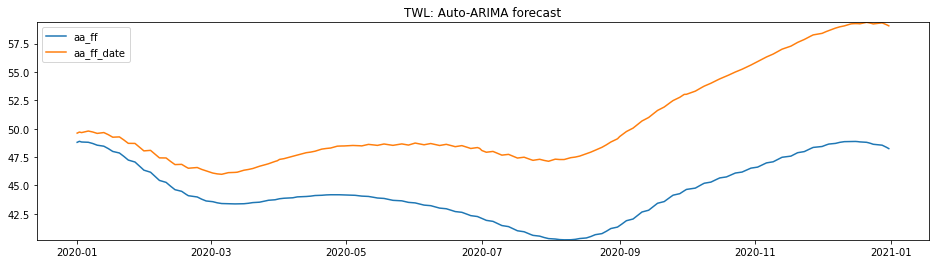

In [79]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = 1
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Auto-ARIMA with FourierFeaturizer forecast output')

#Drop unwated columns from plot = year
aa_plot = pred_data.filter(regex = '^aa_', axis = 1) #regex filter for aa

splt = axes[0][0]                    
splt.plot(pred_data['ds'], aa_plot) 
#Set ylimit for better visualization
splt.set_ylim(aa_plot.min().min(), min(data[agg_value_col].max() * 2, aa_plot.max().max()))
splt.legend(aa_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

plt.show()

##### Using FB Prophet

In [80]:
pred_dates_cap = pred_dates.copy()
#Required for growth = "logistic"
pred_dates_cap['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata.head(), pred_dates_cap.head()

(          ds          y         cap
 0 2008-04-21  12.733235  274.002708
 1 2008-04-22  60.442093  274.002708
 2 2008-04-23  63.995399  274.002708
 3 2008-04-24  61.766136  274.002708
 4 2008-04-25  60.514153  274.002708,
                  ds         cap
 work_doy                       
 1        2020-01-01  274.002708
 2        2020-01-02  274.002708
 3        2020-01-03  274.002708
 4        2020-01-06  274.002708
 5        2020-01-07  274.002708)

In [81]:
for mode in fb_smodes:
    for trend in fb_growth:
        t = trend[0:3]
        m = 's' + mode[0:1]
        fb_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, growth=trend, seasonality_mode=mode)
        fb_model.fit(pdata)
        fb_fcast = fb_model.predict(pred_dates_cap)
        pred_data.loc[pred_data.index, f'fb_yhat_{t}_{m}'] = pd.Series(fb_fcast.yhat.values, index = pred_data.index) 
        pred_data.loc[pred_data.index, f'fb_yearly_{t}_{m}'] = pd.Series(fb_fcast.yearly.values, index = pred_data.index) 
        
        #Use break to stop execution after 1 loop for debugging
        #break
    #break        
pred_data

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fb_yhat_lin_sa,fb_yearly_lin_sa,fb_yhat_log_sa,fb_yearly_log_sa,fb_yhat_lin_sm,fb_yearly_lin_sm,fb_yhat_log_sm,fb_yearly_log_sm
work_doy,,,,,,,,,,,,,,,,
1,2020-01-01,50.062483,50.446180,50.428885,49.523405,49.760626,48.797444,49.606199,46.306118,12.438958,58.399615,11.391433,39.237994,0.214802,55.543051,0.199545
2,2020-01-02,54.578702,55.053279,55.458361,48.015878,48.541453,48.886194,49.699940,46.163037,12.413758,58.343002,11.401006,39.060793,0.213935,55.446671,0.199193
3,2020-01-03,53.845858,54.520010,55.009210,46.165355,46.861091,48.825357,49.654149,45.993326,12.361930,58.251457,11.375573,38.874301,0.212773,55.331656,0.198435
4,2020-01-06,51.402031,52.354840,52.840803,44.610395,45.304972,48.801686,49.790729,45.328739,12.050990,57.770228,11.092237,38.260578,0.207518,54.876742,0.193746
5,2020-01-07,51.703170,52.963486,53.557973,45.489792,46.101738,48.750476,49.752149,45.058132,11.898265,57.544240,10.932065,38.038692,0.205191,54.690063,0.191407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2020-12-24,52.675348,43.531693,52.528447,46.143677,50.322183,48.624850,59.224406,3.529964,11.864677,38.121465,10.377911,-14.195293,0.212574,32.120164,0.190860
247,2020-12-28,53.560000,44.608181,53.982906,46.469680,50.463682,48.545249,59.317238,3.532513,12.338756,38.701148,11.126739,-14.828397,0.215598,32.109638,0.197954
248,2020-12-29,54.417307,45.705051,55.218976,47.199846,50.996772,48.455059,59.239738,3.474572,12.398697,38.777072,11.244805,-14.978796,0.215677,32.084020,0.198875


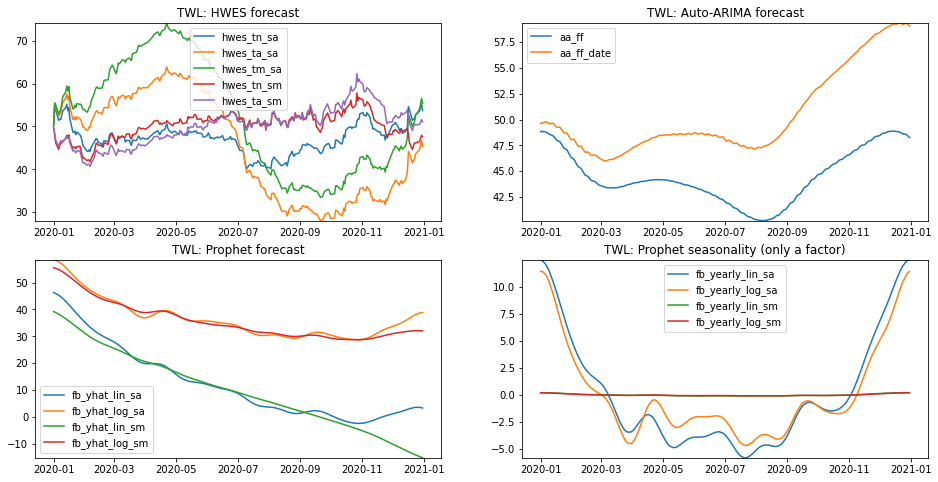

In [82]:
#Plot the forecast output:
columns = 2
rows = 2
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title(f"{stock_tickers[stk]}: Time series forecast output")

splt = axes[0][0]     
hwes_plot = pred_data.filter(regex = '^hwes_', axis = 1) #regex filter for hwes
splt.plot(pred_data['ds'], hwes_plot)
splt.set_ylim(hwes_plot.min().min(), min(data[agg_value_col].max() * 2, hwes_plot.max().max()))
splt.legend(hwes_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

splt = axes[0][1]    
aa_plot = pred_data.filter(regex = '^aa_', axis = 1)#regex filter for autoarima
splt.plot(pred_data['ds'], aa_plot) 
splt.set_ylim(aa_plot.min().min(), min(data[agg_value_col].max() * 2, aa_plot.max().max()))
splt.legend(aa_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

splt = axes[1][0]     
fb_plot = pred_data.filter(regex = '^fb_yhat_', axis = 1) #regex filter for fb prediction
splt.plot(pred_data['ds'], fb_plot)
splt.set_ylim(fb_plot.min().min(), min(data[agg_value_col].max() * 2, fb_plot.max().max()))
splt.legend(fb_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Prophet forecast")

splt = axes[1][1]    
fb_yr_plot = pred_data.filter(regex = '^fb_yearly_', axis = 1)#regex filter for fb seasonality
splt.plot(pred_data['ds'], fb_yr_plot) 
splt.set_ylim(fb_yr_plot.min().min(), min(data[agg_value_col].max() * 2, fb_yr_plot.max().max()))
splt.legend(fb_yr_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Prophet seasonality (only a factor)")

plt.show()

In [83]:
ts_pred_ref = pred_data.groupby(pred_data.ds.dt.year).idxmin()
ts_pred_ref

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fb_yhat_lin_sa,fb_yearly_lin_sa,fb_yhat_log_sa,fb_yearly_log_sa,fb_yhat_lin_sm,fb_yearly_lin_sm,fb_yhat_log_sm,fb_yearly_log_sm
ds,,,,,,,,,,,,,,,,
2020,1,130,181,181,27,27,150,47,208,137,206,138,250,134,207,160


In [84]:
min_wd_pred = sd_pred_ref.transpose().append(ts_pred_ref.transpose()[1:])
min_wd_pred.columns = ['pred_wd_min']
min_wd_pred

,pred_wd_min
sm_add,120
pmd_add,120
sm_mul,32
pmd_mul,32
hwes_tn_sa,130
hwes_ta_sa,181
hwes_tm_sa,181
hwes_tn_sm,27
hwes_ta_sm,27
aa_ff,150


In [85]:
#If there are more than 2 entries for both first month and last month, normalize the data
date_range = 30
if ((min_wd_pred.pred_wd_min < date_range).sum() > 2) & ((min_wd_pred.pred_wd_min > (len(pred_dates) - date_range)).sum() > 2):
    min_wd_pred.loc[min_wd_pred.pred_wd_min < date_range, 'pred_wd_min'] = min_wd_pred.pred_wd_min + len(pred_dates)
min_wd_pred

,pred_wd_min
sm_add,120
pmd_add,120
sm_mul,32
pmd_mul,32
hwes_tn_sa,130
hwes_ta_sa,181
hwes_tm_sa,181
hwes_tn_sm,27
hwes_ta_sm,27
aa_ff,150


In [86]:
df = min_wd_pred.copy()
retry = 0
while ((df.max()[0] - df.min()[0] > date_range) & (retry < 3)) : 
    retry = retry + 1
    #print(retry)
    #print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
    outlier_ratio = retry #1.25
    df = df * df.sub(df.mean()).div(df.std()).abs().lt(outlier_ratio)     
    #print(df)
    #Remove outliers indicated by 0 
    df = df[df.pred_wd_min > 0]
    #print(df)
    continue
        
output_range = df.sort_values(by='pred_wd_min')
output_range

,pred_wd_min
sm_add,120
pmd_add,120
hwes_tn_sa,130
fb_yearly_lin_sm,134
fb_yearly_lin_sa,137
fb_yearly_log_sa,138
aa_ff,150
fb_yearly_log_sm,160
hwes_ta_sa,181
hwes_tm_sa,181


In [87]:
if (output_range.max()[0] - output_range.min()[0] > 30) :
    print('Seasonality not indicated by stock')
else: 
    to_date = int(output_range.max()[0])       
    if int(output_range.max()[0]) > len(pred_dates):
        to_date = to_date - len(pred_dates)
    print('Predicted Working day range for stock to have min. value =', 
      int(output_range.min()[0]), 'to', to_date, 'with median at', output_range.median()[0])

Seasonality not indicated by stock


Notes:
<ol>
    <li>Since data is going to be widely different for each stock, we need to do anlysis and model fitting separately for each stock</li>
    <li>Since this is going to be an yearly exercise, or at best a monthly exercise, we will have to re-run this exercise every cycle with latest data</li>
    <li>I have used 5 techniques and about 4 basic variations of each of them</li>
    <li>Compare the avg. and best price prediction accuracy of last 5 years for all the above variations</li>
    <li>Select the top 5 models below 15 days absolute error i.e. 30 days time frame</li>
    <li>Use the top 5 models for next year's best invesment day prediction</li> 
    <li>Get the average, with yearly round off for values close to start and end of year. For avg. above 365 subtract 365</li>
</ol>

Remember: 
    SMAPE = 2 * (actual - pred) / (actual + pred)
    
SMAPE is not a good accuracy metric for our scenario will be larger for values near to start of year as compare to values at end of year with the same value of absolute diff. in predicted and actual values.